In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [33]:
# python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, cast, Date

In [34]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [35]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\atlas\AppData\Local\Temp\ipykernel_41052\930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [36]:
# View all of the classes that automap found

# access the reflected classes
reflected_classes = Base.classes

# print the names of all the reflected classes
for class_name in reflected_classes.keys():
    print(class_name)

measurement
station


In [37]:
# save references to each table

# station table
station = Base.classes.station

# measurement table
measurement = Base.classes.measurement



In [38]:
# create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [39]:
# find the most recent date in the data set.
most_recent_string = session.query(func.max(measurement.date)).scalar()

# convert to date from string
most_recent_date = pd.to_datetime(most_recent_string)

# show date
most_recent_date


Timestamp('2017-08-23 00:00:00')

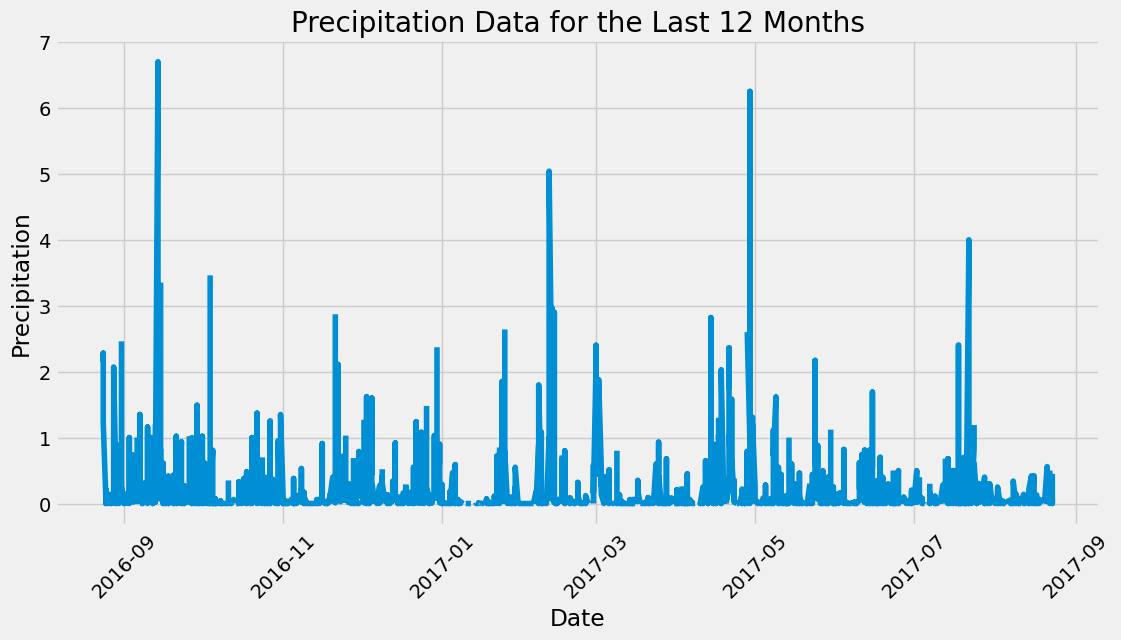

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# calculate the date one year from the last date in data set.
twelve_months_before = most_recent_date - pd.DateOffset(months=12)

# perform a query to retrieve the data and precipitation scores
query = f"SELECT date, prcp FROM measurement WHERE date BETWEEN '{twelve_months_before}' AND '{most_recent_date}'"

# save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.read_sql_query(query, engine)

# assign explicit column names to the dataframe
precipitation_df.columns = ['Date', 'Precipitation']

# Sort the dataframe by date
# make sure date is datetime
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])

# sort by date column
precipitation_df = precipitation_df.sort_values('Date')

# use pandas/matplotlib to plot the data
plt.figure(figsize=(12, 6))
plt.plot(precipitation_df['Date'], precipitation_df['Precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation Data for the Last 12 Months')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [41]:
# Use Pandas to calculate the summary statistics for the precipitation data

# define stats in dictionary
summary_statistics = {
    'count': 'count',
    'mean': 'mean',
    'std': 'std',
    'min': 'min',
    '25%': lambda x: x.quantile(0.25),
    '50%': lambda x: x.quantile(0.5),
    '75%': lambda x: x.quantile(0.75),
    'max': 'max'
}

# apply the aggregate function 
summary_result = precipitation_df['Precipitation'].aggregate(summary_statistics)

# add to dataframe
summary_df = pd.DataFrame(summary_result)

# display df
summary_df

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [42]:
# define the column 
column_to_count = measurement.station

# query to count number of unique values
unique_count = session.query(func.count(func.distinct(column_to_count))).scalar()

# print the count
unique_count


9

In [43]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# build query to list unique values and total row count for each unique value
stmt = session.query(column_to_count, func.count().label('total_count')) \
            .group_by(column_to_count) \
            .order_by(func.count().desc())

# execute query
results = stmt.all()

# print results 
for row in results:
    print(row)

## Question : Which station id has the greatest number of observations?
## Answer : Station USC00519281, with 2772 observations.

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [44]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# top result from last query
top_result = stmt.first()

if top_result:
    # get the values 
    top_column_value = top_result[0]

    # assign temperature column to variable
    count_column = measurement.tobs

    # build a query to find the lowest, highest, and average of another column for the top result
    stmt_temperature = session.query(func.min(count_column), func.max(count_column), func.avg(count_column)) \
                                .filter(column_to_count == top_column_value)

    # execute the query and fetch the results
    result_another_column = stmt_temperature.first()

    # print lowest/highest/average for temp
    print(f"Lowest: {result_another_column[0]}, Highest: {result_another_column[1]}, Average: {result_another_column[2]}")
else:
    print("No results found from the previous query.")


Lowest: 54.0, Highest: 85.0, Average: 71.66378066378067


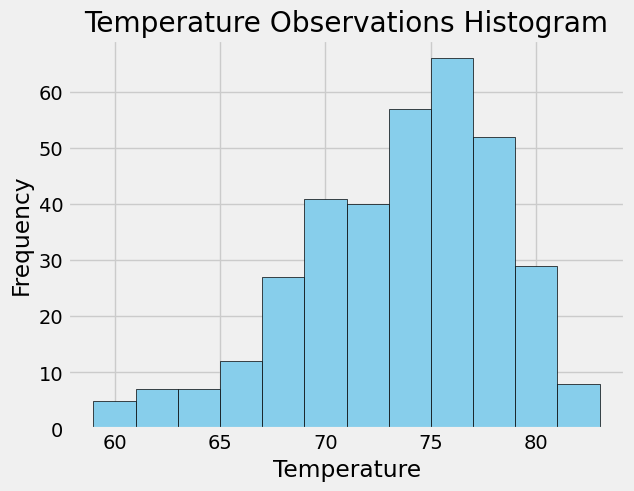

In [50]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# convert dates from timestamp to date
twelve_months_before_dt = twelve_months_before.to_pydatetime()
most_recent_date_dt = most_recent_date.to_pydatetime()

# filter column 
filter_column = measurement.date

# query the tobs data for the top station for the 12 months
results = session.query(measurement).filter(measurement.station == top_column_value,
                                      measurement.date.between(twelve_months_before_dt, most_recent_date_dt)).all()

# extract the temperature values 
temperatures = [result.tobs for result in results]

# plot the histogram 
plt.hist(temperatures, bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations Histogram')
plt.show()


# Close Session

In [16]:
# close Session
session.close()